In [1]:
import os
import libtts

import numpy as np

import matplotlib.pyplot as plt

## ground detection

In [ ]:
# set input file
infile = f"tree_228.pts"

In [ ]:
# set output files
out_gd_file = f"tree_228_gd_xyzh.pts"
out_veg_file = f"tree_228_veg_xyzh.pts"
out_gd_file, out_veg_file = libtts.run_ground_detection(infile = infile, out_gd_file = out_gd_file, out_veg_file = out_veg_file, 
                                                        grid_size=0.1, height_threshold = 0.5)


In [ ]:
# plot gd points
gd_points = np.loadtxt(out_gd_file)
plt.figure(figsize=(7, 7))
plt.scatter(gd_points[:, 0], gd_points[:, 1], c=gd_points[:, 3], s=1, cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title('Ground Points')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
#plt.savefig('ground_points.png')
plt.show()
plt.close()

## tree detection

In [ ]:
tls_veg_file = "close_stems_3.pts"

In [ ]:
tree_locfile = libtts.run_tree_detection(infile = tls_veg_file, outfile= "tree_locations.pts", 
                                         method='base',
                                         height_min=0.5, height_max=1.0, max_avg_dist=1.0,
                                         eps=0.2, min_samples=5)

print(tree_locfile)

In [ ]:
# plot tree locations
tree_locs = np.loadtxt(tree_locfile)
plt.figure(figsize=(7, 7))
plt.scatter(tree_locs[:, 0], tree_locs[:, 1], c=tree_locs[:, 3], s=10, label='Tree Locations')
plt.title('Tree Locations')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.legend()
#plt.savefig('tree_locations.png')
plt.show()
plt.close()

In [ ]:
tls_veg_file = "aoi_xyz_vg_xyzh.ply"
#show_ply_point_summary(tls_veg_file)


In [ ]:
from plyfile import PlyData, PlyElement

tls_veg_file = "aoi_xyz_vg_xyzh.ply"
ply_data = PlyData.read(tls_veg_file)
vertices = ply_data['vertex']
data = [vertices['x'], vertices['y'], vertices['z'], vertices['h']]

# select points with 0.5 < h < 1.0
data = np.array(data).T
th_low = 0.5# 1.25#1.5 # 0.5
th_high = 1.0 # 1.75#2.0 # 1.0
mask = (data[:, 3] > th_low) & (data[:, 3] < th_high)
data = data[mask]
print(f"Filtered points: {len(data)} within height range ({th_low}, {th_high})")


# save to new PLY file
out_ply_file = f"filtered_tree_points_{th_low:.2f}.ply"
out_vertices = np.array([(x, y, z, h) for x, y, z, h in data], 
                         dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('h', 'f4')])
out_ply_data = PlyData([PlyElement.describe(out_vertices, 'vertex')])
out_ply_data.write(out_ply_file)
print(f"Filtered tree points saved to {out_ply_file}")

# save to xyz pts file
out_pts_file = f"filtered_tree_points_{th_low:.2f}.pts"
np.savetxt(out_pts_file, data[:, :3], fmt='%.3f')

In [ ]:
out_ply_file = "filtered_tree_points.ply"

In [ ]:

# geometry-based tree detection
tree_locfile = libtts.run_tree_detection(infile = out_ply_file, outfile= "tree_locations.pts", 
                                         method='geometry',
                                         height_min=0.5, height_max=1.0, 
                                         n_neighbors_pca = 20,
                                         max_linearity=0.2, max_knn_dist = 0.02,
                                         eps=0.1, min_samples=20)

print(tree_locfile)

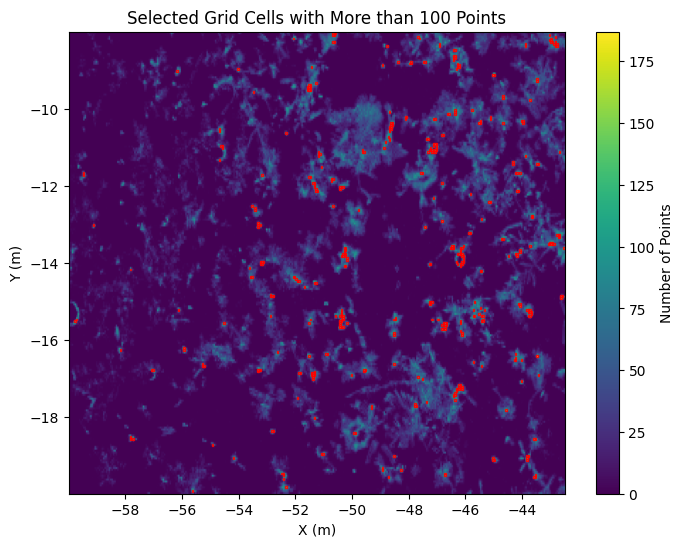

Histogram statistics: >50 points per cell
Shape: (3824,)
Total points: 279161.0
Max points in a cell: 187.0
Min points in a cell: 51.0
Mean points in a cell: 73.00235355648536
Std points in a cell: 21.749350606005404
Found 98 clusters using the gridding method.
Saved 46512 points to tree_locations_gridding.pts
tree_locations_gridding.pts


In [2]:
# gridding-based tree detection

ptsfile = "filtered_tree_points_0.50.ply"
tree_locfile = libtts.run_tree_detection(infile = ptsfile, outfile= "tree_locations_gridding.pts", 
                                         method='grid',
                                         height_min=0.5, height_max=1.0, 
                                         grid_size = 0.05,
                                         eps=0.1, min_samples=2,
                                         does_plot=True)

print(tree_locfile)

In [ ]:
# plot tree locations
tree_locs = np.loadtxt(tree_locfile)
plt.figure(figsize=(7, 7))
# use colormap: flag based on tree_locs[:, 3] (label)
plt.scatter(tree_locs[:, 0], tree_locs[:, 1], c=tree_locs[:, 3], s=10, cmap='flag', label='Tree Locations')
plt.title('Tree Locations')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.legend()
#plt.savefig('tree_locations.png')
plt.show()
plt.close()

In [ ]:
pts_infofile = "debug_geometry_values_1.25.pts"
pts_info = np.loadtxt(pts_infofile)
print(pts_info.shape) # x y z linearity knn_dist

In [ ]:
# place poins in a 2D grid with width th_w, count the number of points in each cell
# and select grid cells with more than th_num points

#pts_infofile = "debug_geometry_values_1.25.pts"
pts_infofile = "filtered_tree_points_0.50.pts"
pts_info = np.loadtxt(pts_infofile)

th_w = 0.05
x_min, x_max = pts_info[:, 0].min(), pts_info[:, 0].max()
y_min, y_max = pts_info[:, 1].min(), pts_info[:, 1].max()
x_bins = np.arange(x_min, x_max + th_w, th_w)
y_bins = np.arange(y_min, y_max + th_w, th_w)
hist, x_edges, y_edges = np.histogram2d(pts_info[:, 0], pts_info[:, 1], bins=[x_bins, y_bins])
# plot the histogram
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[x_min, x_max, y_min, y_max], aspect='auto')
plt.colorbar(label='Number of Points')
plt.title('Point Density Histogram')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid(False)
#plt.savefig('point_density_histogram.png')
plt.show()
plt.close()

# show statistics of the histogram, after removing small cells
hist2 = hist[hist > 50]  # remove small cells
print("Histogram statistics:")
print(f"Shape: {hist2.shape}")
print(f"Total points: {hist2.sum()}")
print(f"Max points in a cell: {hist2.max()}")
print(f"Min points in a cell: {hist2.min()}")
print(f"Mean points in a cell: {hist2.mean()}")
print(f"Std points in a cell: {hist2.std()}")

# select grid cells with more than th_num points
th_num = 100
selected_cells = np.argwhere(hist > th_num)

# plot the selected cells
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[x_min, x_max, y_min, y_max], aspect='auto')
for cell in selected_cells:
    plt.gca().add_patch(plt.Rectangle((x_edges[cell[0]], y_edges[cell[1]]), th_w, th_w, edgecolor='red', facecolor='none', lw=1, alpha = 0.9))
plt.colorbar(label='Number of Points')
plt.title('Selected Grid Cells with More than {} Points'.format(th_num))
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
#plt.savefig('selected_grid_cells.png')
plt.show()
plt.close()

In [ ]:
# dbscan of selected cells

from sklearn.cluster import DBSCAN
# Get the coordinates of the selected cells
selected_coords = np.array([[x_edges[cell[0]], y_edges[cell[1]]] for cell in selected_cells])
# Perform DBSCAN clustering on the selected coordinates
th_eps = 0.1
th_min_samples = 2
dbscan = DBSCAN(eps=th_eps, min_samples=th_min_samples)
dbscan.fit(selected_coords)
# find valid clusters, labels are -1 for noise, 0 for first cluster, 1 for second cluster, etc.
valid_labels = np.unique(dbscan.labels_)
# Filter out noise points
valid_labels = valid_labels[valid_labels != -1]
# Plot the selected cells with DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, origin='lower', cmap='viridis', extent=[x_min, x_max, y_min, y_max], aspect='auto')
for label in valid_labels:
    cluster_cells = selected_cells[dbscan.labels_ == label]
    for cell in cluster_cells:
        plt.gca().add_patch(plt.Rectangle((x_edges[cell[0]], y_edges[cell[1]]), th_w, th_w, edgecolor='red', facecolor='none', lw=1))
plt.colorbar(label='Number of Points')
plt.title('DBSCAN Clusters of Selected Grid Cells')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
#plt.savefig('dbscan_clusters_selected_cells.png')
plt.show()
plt.close()

In [ ]:
# label points with in the clustered grid cells
clustered_points = [] # xyzl
for cell in selected_cells:
    if dbscan.labels_[np.where((selected_cells == cell).all(axis=1))[0][0]] != -1:  # Check if the cell is part of a cluster
        cell_points = pts_info[(pts_info[:, 0] >= x_edges[cell[0]]) & (pts_info[:, 0] < x_edges[cell[0]] + th_w) &
                               (pts_info[:, 1] >= y_edges[cell[1]]) & (pts_info[:, 1] < y_edges[cell[1]] + th_w)]
        cell_lbl = dbscan.labels_[np.where((selected_cells == cell).all(axis=1))[0][0]]
        cell_lbl = cell_lbl + 1 # start labels from 1, not 0
        # make xyzl
        clustered_points.append(np.hstack((cell_points, np.full((cell_points.shape[0], 1), cell_lbl))))
# Concatenate all clustered points
clustered_points = np.vstack(clustered_points) if clustered_points else np.empty((0, 4))
# Save clustered points to a new file
out_clustered_file = "clustered_tree_points.pts"
np.savetxt(out_clustered_file, clustered_points, fmt='%.3f %.3f %.3f %d')

In [ ]:
# select points with linearity < 0.2 and knn_dist < 0.02
mask = (pts_info[:, 3] < 0.2) & (pts_info[:, 4] < 0.02)
filtered_pts_info = pts_info[mask]
print(f"Filtered points: {len(filtered_pts_info)} with linearity < 0.2 and knn_dist < 0.02")

In [ ]:
pts_lbl = libtts.cluster_points_dbscan(filtered_pts_info[:, :3], eps=0.05, min_samples=20, use_2d=True)
pts_lbl.shape

In [ ]:
tree_locfile = "tree_locations_dbscan.pts"
np.savetxt(tree_locfile, pts_lbl, fmt="%.3f")

In [ ]:
# plot tree locations
tree_locs = np.loadtxt(tree_locfile)
plt.figure(figsize=(7, 7))
plt.scatter(tree_locs[:, 0], tree_locs[:, 1], c=tree_locs[:, 3], s=10, label='Tree Locations')
plt.title('Tree Locations')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.axis('equal')
plt.legend()
#plt.savefig('tree_locations.png')
plt.show()
plt.close()

## tree extraction

In [ ]:
### generate alpha shape
th_alpha_sq = 0.01
as_file = libtts.generate_alpha_shape(tls_veg_file, th_alpha_sq)
print("Alpha shape file:", as_file)

In [ ]:
### tree segmentation
as_file = f"{tls_veg_file[:-4]}_a0.010.off"
treeloc_file = f"{tls_veg_file[:-4]}_treeloc_xyzl.pts"
print(f"{as_file=}, {treeloc_file=}")

segfile = libtts.tls_extract_single_trees(as_file, treeloc_file, th_p2trunk_distance=0.2, th_search_radius=0.25)

print(segfile) 

In [ ]:
### label remaining points
tls_veg_file = "close_stems_3.pts"
segfile = f"{tls_veg_file[:-4]}_a0.010_lbl.pts"

all_pts = np.loadtxt(tls_veg_file)
initial_labels = np.loadtxt(segfile)
all_lbl_file = f"{tls_veg_file[:-4]}_lbl_all.pts"
all_pts_lbls = libtts.label_points_region_growing(all_pts, initial_labels, search_radius=0.5, out_file=all_lbl_file)

## downsampling

In [ ]:
infile = "t109_roi.pts"


In [ ]:
dsfile = libtts.run_downsampling(infile, input_data = "pts", th_alpha_sq=0.01, th_avg_dis=0.1)

print(dsfile)

In [ ]:
as_file = "t109_roi_a0.010.off"
dsfile = libtts.run_downsampling(as_file, input_data = "mesh", th_alpha_sq=0.01, th_avg_dis=0.1)


In [ ]:
overseg_file = "t109_roi_a0.010_lbl.pts"
dsfile = libtts.run_downsampling(overseg_file, input_data = "overseg", th_alpha_sq=0.01, th_avg_dis=0.1)

## aux functions

In [ ]:
from plyfile import PlyData
import numpy as np

In [ ]:
def show_ply_point_summary(filepath):
    """
    Reads a PLY file and prints a summary of its point data.

    Args:
        filepath (str): The path to the PLY file.
    """
    try:
        plydata = PlyData.read(filepath)
        
        # show element names and properties
        print(f"Reading PLY file: {filepath}")
        print("Elements in the PLY file:")
        for element in plydata.elements:
            print(f"  - {element.name}: {len(element.data)} points")
            print(f"    Properties:")
            for prop in element.data.dtype.names:
                print(f"      - {prop}: {element.data.dtype[prop]}")
        print("\nPoint data summary:")

        element_names = [element.name for element in plydata.elements]
        if 'vertex' in element_names:
            vertex_data = plydata['vertex'].data
            print(f"Number of points: {len(vertex_data)}")

            # # Print information about the properties (e.g., x, y, z, color)
            # print("Point properties and their data types:")
            # for prop_name in vertex_data.dtype.names:
            #     print(f"  - {prop_name}: {vertex_data.dtype[prop_name]}")

            # Print min/max values for specific properties 
            # if # of pts is relatively small, otherwise it may take too long
            if len(vertex_data) < 1000000 and \
               'x' in vertex_data.dtype.names and \
               'y' in vertex_data.dtype.names and \
               'z' in vertex_data.dtype.names:
                print("\nCoordinate ranges:")
                print(f"  X-range: [{vertex_data['x'].min():.4f}, {vertex_data['x'].max():.4f}]")
                print(f"  Y-range: [{vertex_data['y'].min():.4f}, {vertex_data['y'].max():.4f}]")
                print(f"  Z-range: [{vertex_data['z'].min():.4f}, {vertex_data['z'].max():.4f}]")
        else:
            print(f"No 'vertex' element found in '{filepath}'.")
            print("Available elements:", [el.name for el in plydata.elements])

    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
show_ply_point_summary("/home/alex/Projects/libTTS_public/cpp/cmake-build-debug/close_stems_3_a0.01.ply")

In [ ]:
show_ply_point_summary("/home/alex/Projects/libTTS_public/cpp/cmake-build-debug/close_stems_3_a0.01_lbl.ply")

In [ ]:
show_ply_point_summary("/run/media/alex/HDD_Data3/GoogleDrive/ResearchDevelopment/projects/john_postdoc_2024/test_data/aoi_vg_xyzh_a0.100.ply")